# Trabalho avaliativo

Sistemas de controle II - 2022.4

Controle Digital

**Entrega: 14/12/2022**

Aluno:

Matrícula:



## 1.

*Faça um ensaio dissertativo do seu entendimento sobre controle digital. Procure responder as seguintes perguntas no seu texto:*

* *O que é controle automático digital?* 
* *Qual a diferença entre controle automático digital e analógico?* 
* *O que é necessário para implantar um sistema de controle digital?* 
* *Quais as vantagens do controle digital sobre o analógico? E as desvantagens?* 

*Sua resposta aqui*

## 2.
**Execute o código abaixo antes de começar a resolver:**

In [1]:
import numpy as np
a = np.random.randint(11,20)
b = np.random.randint(1,10)
print('a = ',a)
print('b = ',b)


14
8


No problema abaixo, use os valores de "a" e "b" resultantes do código anterior.

*Ao resolver, apresente todos os códigos. Quando necessário, apresente também os cálculos*


*Dado o sistema*
$$
\begin{align}
    G(s) &= \frac{10(s+a)}{s+b}
\end{align}
$$

1. *Defina um período de amostragem adequado para digitalizar a planta*
2. *Projete um controlador digital **por emulação** que forneça:*
    * *Overshoot de no máximo 15%*
    * *Tempo de acomodação no máximo de 1 segundo.*
    * *Erro de regime nulo para entrada degrau*
3. *Obtenha a equação de diferença para implementar o controlador*
4. *Discretize a planta em malha aberta e faça uma simulação em malha fechada com o controlador projetado, para uma referência degrau unitário. Apresente gráficos dos sinais de saída e de controle. Discuta os resultados.*

*Suas respostas e códigos a partir daqui*

# Soluções e espelho de correção

In [2]:
import numpy as np
import control as ct
from IPython.display import display, Math, Latex, Markdown
import sympy as sp

1. O período de amostragem foi solicitado com base na planta e não no projeto da malha. Como a planta é de primeira ordem, podemos usar a constante de tempo como referência. Adotamos um critério de redução de 10x para garantir o teorema da amostragem de Nyquist. 

In [3]:
T = 1/(10*b)
print("Período de amostragem: ", np.round(T,4))

Período de amostragem:  0.0125


Como o valor é "quebrado", podemos arredondar para um valor mais confortável. 

In [4]:
T = np.round(np.round(T,4)*1000)/1000
print("Período de amostragem recalculado: ", np.round(T,4))


Período de amostragem recalculado:  0.012


2. O projeto se inicia com os pólos e polinômio desejado. É importante mostrar esses cálculos em Python e colocar em Latex/Markdown apenas o resultado. Quando você apresenta o resultado sem o cálculo eu não tenho como saber onde você errou. 

In [102]:
# Cálculos referentes aos pólos de MF e polinômio
Mp = 0.14
ts = 1
xi = -np.log(Mp)/np.sqrt(np.pi**2+np.log(Mp)**2)
wn = 4/(ts*xi)
p = -xi*wn+1j*wn*np.sqrt(1-xi**2)
poli = np.poly([p,np.conj(p)])
strpoli = f's^2+{poli[1]}s+{np.round(poli[2],3)}'
print('Amortecimento e frequência natural projetados:')
display(Math(r'\xi = '+f'{np.round(xi,4)}'+r',\quad\omega_n = '+f'{np.round(wn,4)}'))
print("Pólo de MF principal: ")
display(Math(f'{np.round(p,3)}'))
print("Polinômio de MF desejado:")
display(Math(strpoli))

Amortecimento e frequência natural projetados:


<IPython.core.display.Math object>

Pólo de MF principal: 


<IPython.core.display.Math object>

Polinômio de MF desejado:


<IPython.core.display.Math object>

Controle

O controlador deve ter integrador por causa da exigência de regime permanente. Além disso, como todos os pólos e zeros da planta são estáveis, podemos cancelar tudo. Dessa forma, os únicos pólos que vão sobrar na malha são os do controlador. Então, podemos propor um controle do seguinte tipo:

In [83]:
# Precisamos fazer uma junção de strings aqui para poder mostrar
s1 = r'C(s) = \frac{s+'
s2 = f'{b}'
s3 = r'}{s+'
s4 = f'{a}'
s5 = r'}\cdot \frac{K}{s(s+c)}'
strC = s1+s2+s3+s4+s5
print("Controlador proposto: ")
display(Math(strC))

Controlador proposto: 


<IPython.core.display.Math object>

Onde $c$ vamos determinar pela equação de malha.


Note que a primeira parte do controlador $\frac{(s+b)}{(s+a)}$ serve para cancelar a planta.

Já a segunda introduz o integrador e um pólo em $-c$, a determinar. O ganho $K$ também precisa ser determinado.

Em malha aberta conjunto planta+controle fica (perceba os cancelamentos):

In [84]:
#
strG = r'\frac{10(s+' + f'{a}' + r')}{s+' + f'{b}' + r'}'
display(Math(r'C(s)G(s) = ' + strC + r'\cdot' + strG))

<IPython.core.display.Math object>

Em malha fechada, simplificando tudo, temos:
$$
\begin{align}
    \frac{C(s)G(s)}{1 + C(s)G(s)} &= \frac{10K}{s^2+cs+10K}
\end{align}
$$


Basta agora comparar com o polinômio desejado.

In [85]:
#
display(Math(strpoli + r' = s^2+cs+10K'))

<IPython.core.display.Math object>

Podemos resolver por comparação simples:

In [86]:
#
c = poli[1]
K = poli[2]/10
display(Math(rf'c = {c}\\ K={np.round(K,4)}'))

<IPython.core.display.Math object>

Controlador completo

In [87]:
#
strC = r'C(s)=\frac{' + '{}(s+{})'.format(np.round(K,4),b) + r'}{' + 's(s+{})(s+{})'.format(a,c) + r'}'
display(Math(strC))

<IPython.core.display.Math object>

Discretização:

In [88]:
num = K*np.array([1,b])
den = np.convolve([1,a,0],[1, c])
C = ct.tf(num,den)
Cz = ct.c2d(C,Ts=T,method='bilinear')

In [89]:
# Controlador discreto
nz = Cz.num[0][0]
dz = Cz.den[0][0]
k1 = nz[0]
nz = nz/k1
str_n='{:.2}\,(z^3{:+.3}\,z^2{:+.3}\,z{:+.3})'.format(*[k1,*nz[1:]])
str_d='z^3{:+.3}\,z^2{:+.3}\,z{:+.3}'.format(*dz[1:])
str_Cz = r'\frac{' + str_n + r'}{' + str_d + r'}'
display(Math(r'C(z) = ' + str_Cz))

<IPython.core.display.Math object>

In [90]:
# Ou em potências negativas, para facilitar a equação de diferenças
def zed(p):
    return r'z^{'+f'{p}'+r'}'

nz1 = ''.join(['1']+['{:+.3}'.format(nz[n])+zed(-n) for n in np.arange(1,4) ])
nz1 = '{:.3}('.format(k1) + nz1 + ')'
dz1 = ''.join(['1']+['{:+.3}'.format(dz[n])+zed(-n) for n in np.arange(1,4) ])

str_Cz1 = r'\frac{' + nz1 + r'}{' + dz1 + r'}'
display(Math(r'C(z) = ' + str_Cz1))

<IPython.core.display.Math object>

3. Equação de diferenças

Obs: O script está bem automatizado para funcionar com qualquer valor de "a" e "b". Porém não era necessário você fazer dessa forma. É perfeitamente aceitável copiar e colocar os valores calculados para apresentar a resposta. 

In [91]:
# Equação de diferenças
def sinal(x,p):
    return f'{x}'+r'[k-'+f'{p}'+r']'

ladod = ''.join(['e[k]']+['{:+.3}'.format(nz[n])+sinal('e',n) for n in np.arange(1,4) ])
ladod = '{:.3}('.format(k1) + ladod + ')'
ladoe = ''.join(['{:+.3}'.format(-dz[n])+sinal('u',n) for n in np.arange(1,4) ])
display(Math(r'u[k] = ' + ladod + ladoe))

<IPython.core.display.Math object>

4. Simulação

In [92]:
# Discretização da planta usando equivalente ZOH
numG = 10*np.array([1,a])
denG = np.array([1,b])
G = ct.tf(numG,denG)
Gz = ct.c2d(G,T,'zoh')

n2 = '{}z{:+.2}'.format(*(Gz.num[0][0].tolist()))
d2 = '{}z{:+.2}'.format(*(Gz.den[0][0].tolist()))
display(Math(r'G(z)=\frac{'+n2+'}{'+d2+'}'))

<IPython.core.display.Math object>

# <a id='ajuste'> </a>

In [142]:
# Cálculo das funções de transferência de MF, contínuo e discreto
ka = 1                      # Ganho do ajuste fino. Explicado mais a frente
YRz = ct.feedback(ct.series(Gz,ka*Cz),1)
YR = ct.feedback(ct.series(G,C),1)
print('Função de MF, referência para saída:')
YRz

Função de MF, referência para saída:


TransferFunction(array([ 0.00169924,  0.00042785, -0.00294569, -0.00037798,  0.00129632]), array([ 1.00169924, -3.66145156,  5.0194607 , -3.058253  ,  0.69864436]), 0.012)

In [143]:
# Análise de pólos e zeros
print('Polos de MF:')
tabela = ct.damp(YRz)
print('')
print('Zeros:')
print(np.round(ct.zeros(YRz),3))

Polos de MF:
_____Eigenvalue______ Damping___ Frequency_
    0.9519  +0.06791j     0.5492      7.102
    0.9519  -0.06791j     0.5492      7.102
    0.9084                     1    -0.9084
    0.8431                     1    -0.8431

Zeros:
[-1.   +0.j -1.   +0.j  0.908+0.j  0.84 +0.j]


Observe que, **neste caso específico de "a" e "b"**:
* O amortecimento ficou um pouco abaixo do esperado. Então podemos esperar um overshoot maior
* Temos dois polos adicionais, mas eles são plenamente cancelados por dois zeros
* Temos dois zeros em $-1$, que provavelmente vieram da discretização e não devem afetar nosso transitório

In [144]:
# Resumo dos resultados
info = ct.step_info(YRz)
print('Overshoot real = {:.4} %'.format(info['Overshoot']))
print('Tempo de acomodação = {:.4} seg'.format(info['SettlingTime']))

Overshoot real = 12.57 %
Tempo de acomodação = 0.828 seg


Vemos então que, em termos de overshoot ficamos abaixo do que foi pedido mas um pouco acima do que foi realmente projetado (14%). Também ficamos um pouco acima do tempo de acomodação, mas não muito. Isso provavelmente é devido ao atraso natural causado pela discretização. Talvez tivesse sido mais prudente projetar um tempo de acomodação ligeiramente menor, já prevendo isso. 

In [145]:
# Simulação
t,y = ct.step_response(YR,2)
td,yd = ct.step_response(YRz,2)
from matplotlib import pyplot as plt

O máximo sinal contínuo foi:  1.139819269149283
O máximo sinal discreto foi:  1.1257026595417274


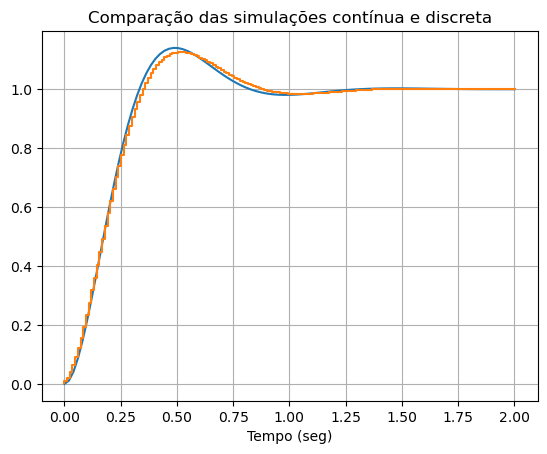

In [146]:
# Simulação
plt.plot(t,y)
plt.title('Comparação das simulações contínua e discreta')
plt.step(td,yd)
plt.xlabel('Tempo (seg)')
plt.grid()
print('O máximo sinal contínuo foi: ', max(y))
print('O máximo sinal discreto foi: ', max(yd))

Observe que no analógico fomos bem, dentro das especificações.

Note que o discreto pode às vezes parecer um pouco adiantado em relação ao contínuo, mas isso é apenas um problema gráfico de como o Python liga os pontos no gráfico. 

Se a perda no tempo de acodomodação for incômoda, podemos tentar fazer um ajuste fino no ganho do controlador, variando um pouco em torno do que foi calculado para ver se melhora. Para isso, basta ajustar o valor da variável "ka" na <a href='#ajuste'> célula que calcula a função de malha </a> e rodar a simulação novamente (sugerido uma redução ou aumento em torno de 10%). 

Por fim, uma breve análise do sinal de controle

O máximo sinal de controle foi:  0.06945513544669092


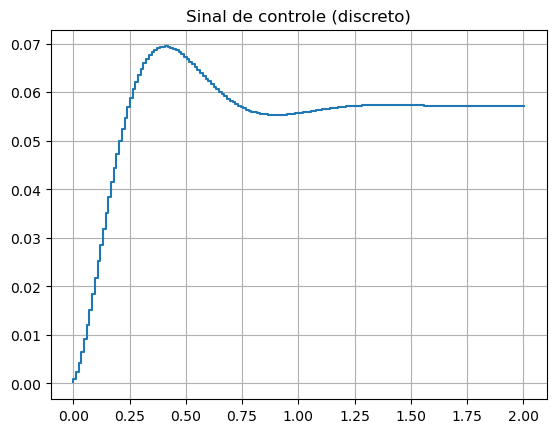

In [150]:
# Função de MF entre a referência e o sinal de controle
URz = Cz/(1+Cz*Gz)
td,ud = ct.step_response(URz,2)
plt.step(td,ud)
plt.grid()
plt.title('Sinal de controle (discreto)')
print('O máximo sinal de controle foi: ', max(ud))

O transitório é semelhante ao da saída, sem variações bruscas. O valor máximo não chega a 1, o que parece razoável. 